# <center> Homework 2: Gaussian Mixture Model (GMM) </center>
<div>
    <center> RAZAFINDRAZAKA Henintsoa </center>
    <center> WANG James </center>
    <center> ____________</center>
    <center> ING5 SI GR02 </center>
    <center> 16/10/2020 </center>
</div>

# <center> [Task] </center>


> Implement yourself the GMM algorithm for Example 1 (density estimation for a Gaussian mixture) given in the Lab 2 document, but now in 3 dimensions (instead of 2 dimensions, which was the case in Example 1).


## 1. Data Generation

### 1.1. Dataset 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

n_samples = 300
# generate random sample, two components 
np.random.seed(0)

# generate spherical data centered on (20, 20)
first = np.random.randn(n_samples, 3) + np.array([0, 2, -8])
second = np.random.randn(n_samples, 3) + np.array([-10, 19, 1])
third = np.random.randn(n_samples, 3) + np.array([7, 17, 18])

# concatenate the 3 datasets into the final training set 
data1 = np.vstack([first, second, third])
print("dataset_1's shape: ",data1.shape)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data1[:, 0], data1[:, 1], data1[:, 2], c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

dataset_1's shape:  (900, 3)


<Figure size 640x480 with 1 Axes>

### 1.2. Dataset 2

dataset_2's shape:  (900, 3)


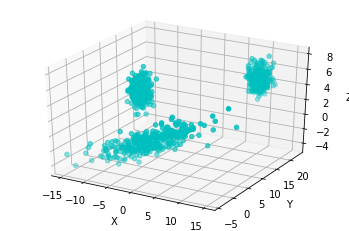

In [2]:

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (10, 20, 5)
shifted_gaussian = np.random.randn(n_samples, 3) + np.array([10, 20, 5])

# generate zero centered stretched Gaussian data
C1 = np.array([[0., -0.7, 1], [3.5, .7, 1], [3.5, .7, 1]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 3), C1)

# generate spherical data centered on (-5, 5, 5)
shifted_gaussian2 = np.random.randn(n_samples, 3) + np.array([-5, 5, 5])

# concatenate the three datasets into the final training set
data2 = np.vstack([shifted_gaussian, stretched_gaussian, shifted_gaussian2])
print("dataset_2's shape: ",data2.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(data2[:, 0], data2[:, 1], data2[:, 2], c='c', marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

### 1. Initialization

In [3]:
# Dataset selection
X_train = data1


In [4]:
# number of clusters 
J = 3

# Dimension of the data
N = X_train.shape[1]
I = X_train.shape[0]

phi = np.full((J,), 1/J)
phi_init = phi

µ = np.zeros((N,J))
for n in range(N):
    for j in range(J):
        µ[n][j] = np.sum(X_train[:,n])/n_samples + np.random.rand()*2
µ_init = µ
        
# Covariance matrix
cov = np.zeros((J,N,N))
for j in range(J):
    for n in range(N):
        cov[j][n][n] = np.random.rand()*10
cov_init = cov

theta = [phi, µ, cov]
print(phi)
print(µ)
print(cov)

[0.33333333 0.33333333 0.33333333]
[[-2.05559386 -2.04207207 -1.98490305]
 [38.40660526 39.78008853 38.45028616]
 [11.25491893 11.34610351 12.49330416]]
[[[7.68545638 0.         0.        ]
  [0.         4.27106808 0.        ]
  [0.         0.         0.13781905]]

 [[9.75735033 0.         0.        ]
  [0.         1.32530977 0.        ]
  [0.         0.         8.51422677]]

 [[7.81723087 0.         0.        ]
  [0.         9.38075782 0.        ]
  [0.         0.         7.73398539]]]


### 2. EM algorithm

##### 2.1 E-step

In [5]:
def E_step(data, params, n_clusters):
    J = n_clusters
    X_train = data
    # Dimensions of the data
    I , N = X_train.shape[0] , X_train.shape[1]
    
    [phi, µ, cov] = params
    
    W = np.zeros((I,J))
    
    for i in range(I):
        for j in range(J):
            X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
            expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
            Wnum = ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[j])**(1/2)) ) * expo * phi[j]
            Wdenom = 0
            for k in range(J):
                X_µ = (X_train[i] - µ[:,k]).reshape(N,1)
                expo = np.exp( -0.5 * np.dot( X_µ.T , np.linalg.inv(cov[j]) ).dot(X_µ) )
                Wdenom +=  ( 1 / ( (2*np.pi)**(N/2) * np.linalg.det(cov[k])**(1/2)) ) * expo * phi[k]

            W[i][j] = Wnum / Wdenom
            if np.isnan(W[i][j]):
                W[i][j] = 0
    return W

##### 2.2 M-step : 
##### Model Parameters θ = (ϕ,µ,Σ) update 

In [6]:
def M_step(data, distribution_Z, n_clusters):
    J = n_clusters
    X_train = data
    # Dimensions of the data
    I , N = X_train.shape[0] , X_train.shape[1]
    
    [phi, µ, cov] = [np.full((J,), 1/J), np.zeros((N,J)), np.zeros((J,N,N))]
    
    W = distribution_Z
    
    # Update of phi
    for j in range(J):
        phi[j] = W[:,j].sum() / I

    # Update of µ
    for j in range(J):
        num = np.zeros((X_train[0].shape))
        denom = W[:,j].sum()
        
        for i in range(I):
            num += W[i][j] * X_train[i]
        µ[:,j] = num / denom

    # Update of cov (= sigma)
    for j in range(J):
        num = np.zeros(cov[0].shape)
        denom = W[:,j].sum()

        for i in range(I):
            X_µ = (X_train[i] - µ[:,j]).reshape(N,1)
            num += W[i][j] * X_µ.dot( X_µ.T ) 
        cov[j] = num / denom

    return [phi, µ, cov]

##### 2.3 EM algo loop until convergence

In [7]:
e = 0.001

# n_clusters
J = 3 

# Dimensions of the data
I , N = X_train.shape[0] , X_train.shape[1]

#################### Model Parameters initialization ####################
# phi init
phi_init = np.full((J,), 1/J)
phi = phi_init

# µ init
µ_init = np.zeros((N,J))
for n in range(N):
    for j in range(J):
        µ_init[n][j] = np.random.rand()*10 + np.sum(X_train[:,n])/n_samples 
µ = µ_init
        
# Covariance matrix init
cov_init = np.zeros((J,N,N))
                   
for j in range(J):
    for n in range(N):
        cov_init[j][n][n] = np.random.rand()*10
cov = cov_init
theta = [phi, µ, cov]

# Initialization of the probability distribution of Z
W = np.zeros((I,J))

In [8]:
#################### Repeat EM algo until convergence ####################

epochs = 1

W_New = E_step(X_train, theta, J) 
[phi_New, µ_New, cov_New] = M_step(X_train, W_New, J)

phi_Old, µ_Old, cov_Old = phi_init, µ_init, cov_init

dif_µ = np.linalg.norm(µ_New - µ_Old)
dif_phi = np.linalg.norm(phi_New - phi_Old)
dif_cov = np.linalg.norm(cov_New - cov_Old)

print('============ Epoch N°', epochs,' ============')
print('|| µ_New - µ_Old || =', dif_µ)
print('|| phi_New - phi_Old || =', dif_phi)
print('|| cov_New - cov_Old || =', dif_cov, '\n')

while dif_µ >= e or dif_phi >= e or dif_cov >= e:
    epochs += 1
    phi_Old, µ_Old, cov_Old = phi_New, µ_New, cov_New
    
    W_New = E_step(X_train, [phi_Old, µ_Old, cov_Old], J) 
    [phi_New, µ_New, cov_New] = M_step(X_train, W_New, J)
    
    dif_µ = np.linalg.norm(µ_New - µ_Old)
    dif_phi = np.linalg.norm(phi_New - phi_Old)
    dif_cov = np.linalg.norm(cov_New - cov_Old)
    
    print('\n============ Epoch N°', epochs,' ============')
    print('|| µ_New - µ_Old || =', dif_µ)
    print('|| phi_New - phi_Old || =', dif_phi)
    print('|| cov_New - cov_Old || =', dif_cov, '\n')
    
print("nb of epochs : ", epochs)


============ Epoch N° 1  ============
|| µ_New - µ_Old || = 54.4729307105226
|| phi_New - phi_Old || = 0.4713904078765233
|| cov_New - cov_Old || = 113.70127989558743 


============ Epoch N° 2  ============
|| µ_New - µ_Old || = 1.3017934117366596
|| phi_New - phi_Old || = 0.33331357725587674
|| cov_New - cov_Old || = 4.384158669219308 


============ Epoch N° 3  ============
|| µ_New - µ_Old || = 7.009446028280467
|| phi_New - phi_Old || = 0.4880758629141916
|| cov_New - cov_Old || = 48.59314242390296 


============ Epoch N° 4  ============
|| µ_New - µ_Old || = 3.7640739822208618
|| phi_New - phi_Old || = 0.024850851622980813
|| cov_New - cov_Old || = 65.52441966214556 


============ Epoch N° 5  ============
|| µ_New - µ_Old || = 0.13632551824360503
|| phi_New - phi_Old || = 0.13026171862207853
|| cov_New - cov_Old || = 4.993986821110788 


============ Epoch N° 6  ============
|| µ_New - µ_Old || = 2.691302202075663e-14
|| phi_New - phi_Old || = 1.6653345369377348e-16
|| cov_New 

### 3. Label prediction

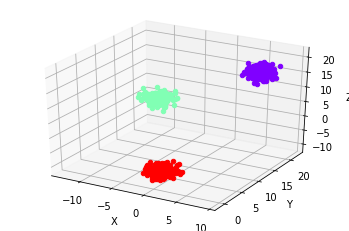

In [9]:
import matplotlib.cm as cm

# Associating the target cluster to each data

labeled_data = []
for j in range(J):
    labeled_data.append([])
    

for i in range(I):
    Wmax = W_New[i][0]
    argZ = 0
    for j in range(1,J):
        if W_New[i][j] > Wmax:
            Wmax = W_New[i][j]
            argZ = j
    labeled_data[argZ].append(X_train[i])

# Displaying the data labeled with a color
colors = cm.rainbow(np.linspace(0, 1, J))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for clusters, c in zip(labeled_data, colors):
    for x in clusters:
        ax.scatter(x[0], x[1], x[2] , color=c)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()